In [34]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers # type: ignore
from datetime import datetime
import cv2
import time


# Import Data

In [35]:
data_train_path='./dataset/dataset/train'
data_test_path='./dataset/dataset/test'

In [36]:
img_width = 180
img_height = 180

In [37]:
# data_val = tf.keras.utils.image_dataset_from_directory(
#     data_val_path,
#     shuffle=True,
#     image_size=(img_width,img_height),
#     batch_size = 32,
#     validation_split=False
# )

In [38]:
data_train = tf.keras.utils.image_dataset_from_directory(
    data_train_path,
    shuffle=True,
    image_size=(img_width,img_height),
    batch_size = 32,
    validation_split=False
)

Found 12247 files belonging to 2 classes.


In [51]:
data_cat = data_train.class_names
print(data_cat)

['fresh', 'rotten']


In [40]:
data_test = tf.keras.utils.image_dataset_from_directory(
    data_test_path,
    shuffle=True,
    image_size=(img_width,img_height),
    batch_size = 32,
    validation_split=False
)

Found 2700 files belonging to 2 classes.


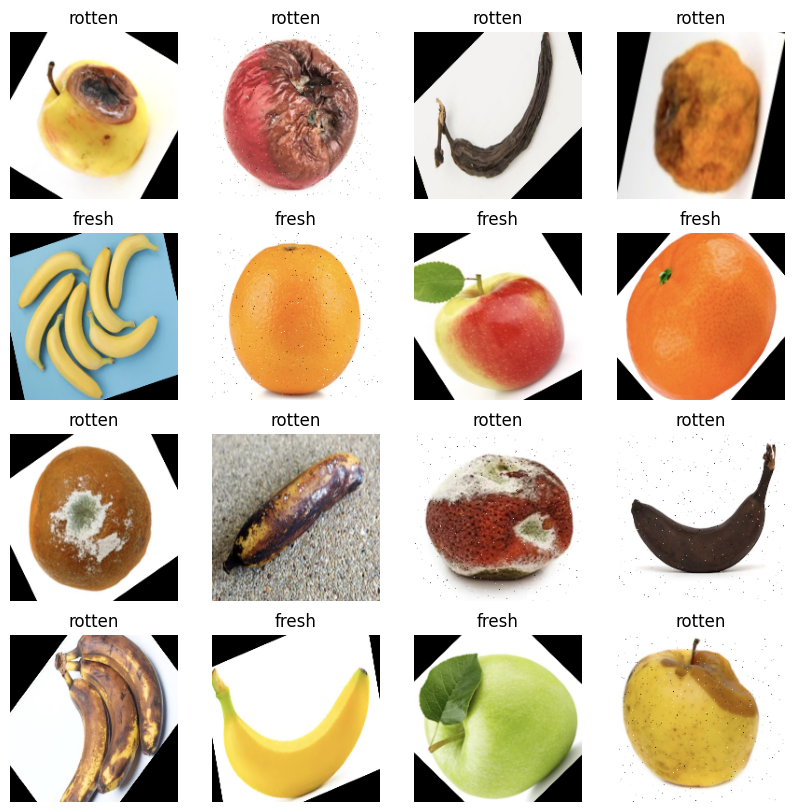

In [41]:
plt.figure(figsize=(10,10))
for image, labels in data_train.take(1):
    for i in range(16):
        plt.subplot(4,4,i+1)
        plt.imshow(image[i].numpy().astype('uint8'))
        plt.title(data_cat[labels[i]])
        plt.axis('off')

# Building Model

In [42]:
from tensorflow.keras.models import Sequential # type: ignore

## Checking GPU

In [43]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

Physical devices cannot be modified after being initialized


## Pushing Model in GPU

In [44]:
gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    # Print GPU details
    print(f"Using GPU: {tf.config.experimental.get_device_details(gpus[0])['device_name']}")
    with tf.device('/GPU:0'):
        # Define your model architecture
        model = Sequential([
        layers.Rescaling(1./255),
        layers.Conv2D(16, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(32,3, padding='same',activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(128),
        layers.Dense(len(data_cat))

    ])

        # Compile the model
        model.compile(optimizer='adam',
                      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                      metrics=['accuracy'])
else:
    print("No GPU detected, running on CPU.")


Using GPU: NVIDIA GeForce RTX 3050 Laptop GPU


# LOAD MODEL

In [66]:
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
epochs_size = 25
# save model
# model.save('gfgModel.h5')
# print('Model Saved!')
#! load model
savedModel=load_model('gfgModel.h5')
savedModel.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 45, 45, 64)       

## Fitting Data

In [27]:
history = model.fit(data_train,validation_data=data_test, epochs=epochs_size)

Epoch 1/25
383/383 [==============================] - 18s 43ms/step - loss: 0.4476 - accuracy: 0.8096 - val_loss: 0.2707 - val_accuracy: 0.8863
Epoch 2/25
383/383 [==============================] - 16s 40ms/step - loss: 0.2514 - accuracy: 0.9004 - val_loss: 0.1843 - val_accuracy: 0.9256
Epoch 3/25
383/383 [==============================] - 18s 48ms/step - loss: 0.2253 - accuracy: 0.9117 - val_loss: 0.1493 - val_accuracy: 0.9452
Epoch 4/25
383/383 [==============================] - 17s 44ms/step - loss: 0.1927 - accuracy: 0.9247 - val_loss: 0.1340 - val_accuracy: 0.9533
Epoch 5/25
383/383 [==============================] - 16s 40ms/step - loss: 0.1731 - accuracy: 0.9338 - val_loss: 0.1276 - val_accuracy: 0.9526
Epoch 6/25
383/383 [==============================] - 16s 40ms/step - loss: 0.1559 - accuracy: 0.9428 - val_loss: 0.1399 - val_accuracy: 0.9485
Epoch 7/25
383/383 [==============================] - 19s 49ms/step - loss: 0.1401 - accuracy: 0.9453 - val_loss: 0.1154 - val_accuracy:

Text(0.5, 1.0, 'Loss')

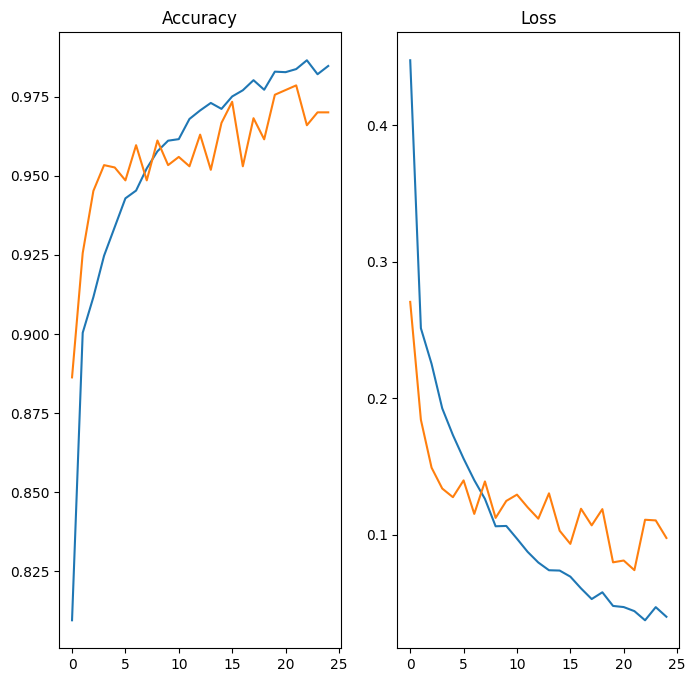

In [67]:
epochs_range = range(epochs_size)
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(epochs_range,history.history['accuracy'],label = 'Training Accuracy')
plt.plot(epochs_range,history.history['val_accuracy'],label = 'Validation Accuracy')
plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(epochs_range,history.history['loss'],label = 'Training Loss')
plt.plot(epochs_range, history.history['val_loss'],label = 'Validation Loss')
plt.title('Loss')

## Using Image File

In [71]:
image_path = './bread.jpg'
image = tf.keras.utils.load_img(image_path, target_size=(img_height, img_width))
img_array = tf.keras.utils.img_to_array(image)
img_array = tf.expand_dims(img_array, 0)  # Create a batch

# Normalize pixel values to be between 0 and 1
img_bat = img_array
predict = savedModel.predict(img_bat)
score = tf.nn.softmax(predict)
predicted_category = np.argmax(score)
accuracy = np.max(score) * 100

1/1 [==============================] - 0s 26ms/step


In [72]:
def determine_shelf_life(accuracy,result):
    if(result == "rotten"):
        if accuracy < 60:
            return 3
        elif 60 <= accuracy < 75:
            return 2
        elif 75 <= accuracy < 90:
            return 1
        elif accuracy > 90:
            return 0
    else:
        return 8
predicted_shelf_life = determine_shelf_life(accuracy,data_cat[predicted_category])

In [73]:

print('Veg/Fruit in image is {} with accuracy of {:0.2f}% and estimated shelf life of {} days'.format(
            data_cat[predicted_category],
            accuracy,
            predicted_shelf_life))

Veg/Fruit in image is rotten with accuracy of 100.00% and estimated shelf life of 0 days


# Detecting using WebCam

In [74]:
# from datetime import datetime
# import cv2
# import time
# import tensorflow as tf
# import numpy as np


def determine_shelf_life(accuracy,result):
    if(result == "rotten"):
        if accuracy < 60:
            return 1
        elif 60 <= accuracy < 75:
            return 2
        elif 75 <= accuracy < 90:
            return 3
        else:
            return 4
    else:
        return 8

def analyze_damage(frame, filename):
    """
    Analyze the image to identify the category (Veg/Fruit) and predict the shelf life.
    """
    try:

        img_height = 180
        img_width = 180

        image = tf.keras.utils.load_img(filename, target_size=(img_height, img_width))
        img_array = tf.keras.utils.img_to_array(image)
        img_array = tf.expand_dims(img_array, 0)  # Create a batch

        # Normalize pixel values to be between 0 and 1
        img_bat = img_array / 255.0


        predict = savedModel.predict(img_bat)
        score = tf.nn.softmax(predict)

        # Get category prediction and its accuracy
        predicted_category = np.argmax(score[0][0])
        accuracy = np.max(score) * 100  # Convert softmax score to percentage

        # Determine shelf life based on accuracy
        predicted_shelf_life = determine_shelf_life(accuracy,data_cat[predicted_category])


        return 'Veg/Fruit in image is {} with accuracy of {:0.2f}% and estimated shelf life of {} days'.format(
            data_cat[predicted_category],
            accuracy,
            predicted_shelf_life
        )

    except Exception as e:
        print(f"Detailed error: {str(e)}")
        return f"Error in analysis. Please check your API key and internet connection."


def main():
    print("Initializing camera...")
    cap = cv2.VideoCapture(0)

    if not cap.isOpened():
        print("Error: Could not open camera")
        return

    print("Camera initialized successfully!")
    print("Press 'A' to analyze the current frame")
    print("Press 'Q' to quit")

    cv2.namedWindow('Damage Analyzer', cv2.WINDOW_NORMAL)

    last_analysis_time = 0
    analysis_result = "Press 'A' to analyze current frame"

    while True:
        ret, frame = cap.read()
        if not ret:
            print("Error: Can't receive frame")
            break

        display_frame = frame.copy()

        # Add instructions
        cv2.putText(display_frame,
                    "'Q' to quit",
                    (10, 30),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    0.7,
                    (0, 255, 0),
                    2)

        # Show analysis result
        y_position = 60
        wrapped_text = [analysis_result[i:i+40] for i in range(0, len(analysis_result), 40)]
        for line in wrapped_text:
            cv2.putText(display_frame,
                        line,
                        (10, y_position),
                        cv2.FONT_HERSHEY_SIMPLEX,
                        0.6,
                        (255, 255, 255),
                        1)
            y_position += 30

        cv2.imshow('Damage Analyzer', display_frame)

        key = cv2.waitKey(1) & 0xFF
        if key == ord('q'):
            print("Exiting...")
            break
        elif key == ord('a'):
            current_time = time.time()
            if current_time - last_analysis_time > 3:
                print("\nAnalyzing frame...")

                # Save the frame
                timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
                filename = f"analyzed_frame_{timestamp}.jpg"
                cv2.imwrite(filename, frame)
                print(f"Frame saved as {filename}")

                # Analyze the frame
                analysis_result = analyze_damage(frame, filename)
                print(f"Analysis result: {analysis_result}\n")

                last_analysis_time = current_time

    cap.release()
    cv2.destroyAllWindows()

main()


Initializing camera...
Camera initialized successfully!
Press 'A' to analyze the current frame
Press 'Q' to quit

Analyzing frame...
Frame saved as analyzed_frame_20241020_222651.jpg
1/1 [==============================] - 0s 22ms/step
Analysis result: Veg/Fruit in image is fresh with accuracy of 72.96% and estimated shelf life of 8 days

Exiting...
